# 03__activs_general

in this notebook, i look at activities of TSSs in native contexts (human seqs in hESCs, mouse seqs in mESCs) compared to negative and positive controls. i also look at diffs in activity between tiles

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def consolidate_cage(row, biotype_col):
    if row[biotype_col] == "reclassified - CAGE peak":
        return "no CAGE activity"
    else:
        return row[biotype_col]

In [5]:
def fix_cleaner_biotype(row, biotype_col):
    try:
        if row["name"] == "random_sequence":
            return "negative control"
        elif "samp" in row.element:
            return "positive control"
        else:
            return row[biotype_col]
    except:
        return row[biotype_col]

In [6]:
def is_sig(row, col):
    if row[col] < 0.05:
        return "sig"
    else:
        return "not sig"

In [7]:
def fix_cage_exp(row, col):
    if row[col] == "no cage activity":
        return 0
    else:
        return float(row[col])

## variables

In [8]:
data_dir = "../../../data/02__mpra/02__activs"
alpha_f = "%s/alpha_per_elem.quantification.txt" % data_dir

In [9]:
index_f = "../../../data/01__design/02__index/TWIST_pool4_v8_final.with_element_id.txt.gz"

In [10]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.RECLASSIFIED.txt"

## 1. import files

In [11]:
alpha = pd.read_table(alpha_f, sep="\t")
alpha.reset_index(inplace=True)
alpha.head()

index    HUES64      mESC  \
0  AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...  7.295239  6.315911   
1  AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...  1.326796  1.348824   
2  AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...  0.977164  1.548916   
3  AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...  0.976127  0.818171   
4  AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...  1.323999  1.457128   

    HUES64_pval     mESC_pval   HUES64_padj     mESC_padj  
0  2.825214e-75  1.383066e-42  4.596852e-74  1.878236e-41  
1  1.451021e-01  2.326515e-01  3.319934e-01  5.455262e-01  
2  4.814953e-01  1.057092e-01  7.164347e-01  3.127558e-01  
3  4.826910e-01  7.414048e-01  7.167637e-01  8.145300e-01  
4  1.469545e-01  1.559242e-01  3.356231e-01  4.172106e-01

In [12]:
index = pd.read_table(index_f, sep="\t")

In [13]:
index_elem = index[["element", "tile_type", "element_id", "name", "tile_number", "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

In [14]:
tss_map = pd.read_table(tss_map_f, sep="\t")
tss_map.head()

hg19_id mm9_id               cage_id_hg19                  cage_id_mm9  \
0     h.0    m.0    chr1:2984976..2984989,-  chr4:154011655..154011673,+   
1     h.1    m.0    chr1:2984997..2985037,-  chr4:154011655..154011673,+   
2     h.2    m.1    chr1:2985420..2985438,-  chr4:154011250..154011257,+   
3     h.3    m.2    chr1:8086546..8086571,+  chr4:150229039..150229050,-   
4     h.4    m.3  chr1:26498321..26498327,-  chr4:133799669..133799683,+   

      name_peak_hg19         name_peak_mm9 biotype_hg19     biotype_mm9  \
0  ENSG00000177133.6  ENSMUSG00000085069.2    divergent       divergent   
1  ENSG00000177133.6  ENSMUSG00000085069.2    divergent       divergent   
2  ENSG00000177133.6  ENSMUSG00000085069.2    divergent       divergent   
3  ENSG00000238290.1  ENSMUSG00000078492.3    divergent       antisense   
4  ENSG00000236782.1  ENSMUSG00000086322.7    antisense  protein_coding   

  minimal_biotype_hg19 minimal_biotype_mm9  ...   end_tss_mm9  strand_tss_mm9  \
0               lncRNA              lncRNA  ...     154011664               +   
1               lncRNA              lncRNA  ...     154011664               +   
2               lncRNA              lncRNA  ...     154011253               +   
3               lncRNA              lncRNA  ...     150229045               -   
4                other                mRNA  ...     133799678               +   

   avg_exp_hg19 avg_exp_mm9         stem_exp_hg19  stem_exp_mm9  \
0           0.1        0.43  0.027777800000000002        0.0175   
1          0.29        0.43             0.0311111        0.0175   
2          2.54        0.85   0.07111110000000001           0.0   
3           0.3        0.14   0.10444400000000001           0.0   
4          0.19        0.25                  0.03           0.0   

   max_cage_hg19 max_cage_mm9 orig_species    har  
0          367.0       2286.0        human  False  
1          367.0       2286.0        human  False  
2         6966.0       1361.0        human  False  
3          960.0        123.0        human  False  
4          753.0        770.0        human  False  

[5 rows x 26 columns]

## 2. merge alphas w/ index

In [15]:
pos_ctrls = alpha[alpha["index"].str.contains("__samp")]
pos_ctrls["HUES64_log"] = np.log10(pos_ctrls["HUES64"])
pos_ctrls["mESC_log"] = np.log10(pos_ctrls["mESC"])
len(pos_ctrls)

400

In [16]:
alpha = alpha[~alpha["index"].str.contains("__samp")]
len(alpha)

13479

In [17]:
data = alpha.merge(index_elem, left_on="index", right_on="element", how="left")
data.drop("index", axis=1, inplace=True)
data.head()

HUES64      mESC   HUES64_pval     mESC_pval   HUES64_padj     mESC_padj  \
0  7.295239  6.315911  2.825214e-75  1.383066e-42  4.596852e-74  1.878236e-41   
1  1.326796  1.348824  1.451021e-01  2.326515e-01  3.319934e-01  5.455262e-01   
2  0.977164  1.548916  4.814953e-01  1.057092e-01  7.164347e-01  3.127558e-01   
3  0.976127  0.818171  4.826910e-01  7.414048e-01  7.167637e-01  8.145300e-01   
4  1.323999  1.457128  1.469545e-01  1.559242e-01  3.356231e-01  4.172106e-01   

                                             element tile_type  \
0  AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...  WILDTYPE   
1  AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...  WILDTYPE   
2  AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...  WILDTYPE   
3  AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...  WILDTYPE   
4  AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...  WILDTYPE   

                                          element_id  \
0  MOUSE_EVO_TSS__m.3163__tile1:53114165-53114309...   
1  HUMAN_EVO_TSS__h.1133__tile1:129255098-1292552...   
2  MOUSE_EVO_TSS__m.596__tile2:136753021-13675316...   
3  MOUSE_EVO_TSS__m.2358__tile2:15536411-15536555...   
4  HUMAN_EVO_TSS__h.1436__tile1:157192113-1571922...   

                           name  tile_number  chrom strand  actual_start  \
0  MOUSE_EVO_TSS__m.3163__tile1          1.0  chr11      -      53114165   
1  HUMAN_EVO_TSS__h.1133__tile1          1.0   chrX      -     129255098   
2   MOUSE_EVO_TSS__m.596__tile2          1.0   chr6      -     136753021   
3  MOUSE_EVO_TSS__m.2358__tile2          1.0  chr14      -      15536411   
4  HUMAN_EVO_TSS__h.1436__tile1          1.0   chr2      +     157192113   

   actual_end    dupe_info  
0    53114309   8265.1.0.0  
1   129255242   7281.1.0.0  
2   136753165  12910.1.0.0  
3    15536555   9294.1.0.0  
4   157192257   4134.1.0.0

In [18]:
data["HUES64_log"] = np.log10(data["HUES64"])
data["mESC_log"] = np.log10(data["mESC"])
data.sample(5)

HUES64      mESC   HUES64_pval     mESC_pval   HUES64_padj  \
5895   2.758273  2.120578  1.006826e-07  3.128699e-03  4.884214e-07   
10316  1.304056  1.356597  1.606228e-01  2.265295e-01  3.598522e-01   
4206   8.062662  6.370035  4.683018e-94  1.997345e-43  9.052313e-93   
8727   0.495777  0.349600  9.108425e-01  9.688609e-01  9.214653e-01   
6673   0.652276  1.256125  8.141533e-01  3.122605e-01  8.588305e-01   

          mESC_padj                                            element  \
5895   1.407104e-02  CTCACAAGCATCTGCAGACTGAAGCCTGACATCCAAGCTCCGGCTC...   
10316  5.361532e-01  GTGTTGTTGCCTAGAGTTTGTCCCAGCGGAGGGTTGGCTTCGGATC...   
4206   2.736540e-42  CCCAGAACCTGCGCGAGGGAGACGCCCCTCCTCTGGCCCCGCCCCA...   
8727   9.706093e-01  GGACAGATGGATCGTCTGCGGTGCAGGTCACGGTACTCGTCAACAC...   
6673   6.394014e-01  CTTGGATAATACAGACTACTGTCCGAGCGGCCGCGCACCCTTGTGT...   

      tile_type                                         element_id  \
5895   WILDTYPE  MOUSE_EVO_TSS__m.265__tile1:101129073-10112921...   
10316  WILDTYPE  HUMAN_EVO_TSS__h.508__tile2:232646166-23264631...   
4206   WILDTYPE  MOUSE_EVO_TSS__m.2627__tile2:59966640-59966784...   
8727     RANDOM                            random_sequence_270;270   
6673     RANDOM                            random_sequence_729;729   

                               name  tile_number  chrom strand  actual_start  \
5895    MOUSE_EVO_TSS__m.265__tile1          1.0  chr15      -     101129073   
10316   HUMAN_EVO_TSS__h.508__tile2          1.0   chr2      +     232646166   
4206   MOUSE_EVO_TSS__m.2627__tile2          1.0   chr8      +      59966640   
8727                random_sequence          0.0    NaN    NaN             0   
6673                random_sequence          0.0    NaN    NaN             0   

       actual_end    dupe_info  HUES64_log  mESC_log  
5895    101129217   9730.1.0.0    0.440637  0.326454  
10316   232646310   4323.1.0.0    0.115296  0.132451  
4206     59966784  13593.1.0.0    0.906478  0.804142  
8727            0         none   -0.304714 -0.456428  
6673            0         none   -0.185569  0.099033

## 3. compare activities across biotypes + controls

In [19]:
data["tss_id"] = data["name"].str.split("__", expand=True)[1]
data["species"] = data["name"].str.split("_", expand=True)[0]
data["tss_tile_num"] = data["name"].str.split("__", expand=True)[2]
data.sample(5)

HUES64      mESC  HUES64_pval  mESC_pval  HUES64_padj  mESC_padj  \
358    0.700698  1.319318     0.774350   0.256707     0.838138   0.576791   
727    1.081096  0.940521     0.364291   0.629301     0.623273   0.776341   
11453  1.407988  2.023896     0.098090   0.006515     0.243322   0.027694   
8967   0.865699  1.168591     0.608727   0.396594     0.777805   0.699274   
12430  0.837084  1.088092     0.640115   0.478802     0.788397   0.735505   

                                                 element tile_type  \
358    AACCTTAGTTGATGGCTGTCCAGCCGGCTGGTTCTTCCCTATTCAA...  WILDTYPE   
727    AATCCCTCACCTTAAACACTGGCCTGCACCACCAAGAAAAGAGAAA...  WILDTYPE   
11453  TCGAACATTCCACGTATCAACCCCACTAGCTAATGGGCCGGAATCT...    RANDOM   
8967   GGCAGCAATGACTTGGTTGAAGCCAGAAACACGGCTCAGGGAGGGC...  WILDTYPE   
12430  TGGTAAAAGTTCTCACTAATCCTCAATATTCCACTTTTTAAAATCT...  WILDTYPE   

                                              element_id  \
358    HUMAN_EVO_TSS__h.2548__tile1:128446499-1284466...   
727    HUMAN_EVO_TSS__h.2549__tile1:53293783-53293927...   
11453                              random_sequence_95;95   
8967   MOUSE_EVO_TSS__m.1478__tile1:118164327-1181644...   
12430  HUMAN_EVO_TSS__h.2883__tile2:26100209-26100353...   

                               name     ...       chrom strand actual_start  \
358    HUMAN_EVO_TSS__h.2548__tile1     ...        chr3      +    128446499   
727    HUMAN_EVO_TSS__h.2549__tile1     ...        chr5      +     53293783   
11453               random_sequence     ...         NaN    NaN            0   
8967   MOUSE_EVO_TSS__m.1478__tile1     ...       chr11      +    118164327   
12430  HUMAN_EVO_TSS__h.2883__tile2     ...        chr2      +     26100209   

       actual_end   dupe_info HUES64_log  mESC_log  tss_id species  \
358     128446643  4984.1.0.0  -0.154469  0.120349  h.2548   HUMAN   
727      53293927  5559.1.0.0   0.033864 -0.026631  h.2549   HUMAN   
11453           0        none   0.148599  0.306188    None  random   
8967    118164471  8690.1.0.0  -0.062633  0.067662  m.1478   MOUSE   
12430    26100353  3765.1.0.0  -0.077231  0.036666  h.2883   HUMAN   

      tss_tile_num  
358          tile1  
727          tile1  
11453         None  
8967         tile1  
12430        tile2  

[5 rows x 21 columns]

In [20]:
pos_ctrls.columns = ["element", "HUES64", "mESC", "HUES64_pval", "mESC_pval", "HUES64_padj", "mESC_padj", 
                     "HUES64_log", "mESC_log"]
pos_ctrls.head()

element     HUES64  \
13479  AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...  10.585288   
13480  AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...  10.611084   
13481  AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...   9.462360   
13482  AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...   8.584887   
13483  AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...   7.873613   

            mESC    HUES64_pval      mESC_pval    HUES64_padj      mESC_padj  \
13479  12.455913  7.760025e-171  1.851729e-192  2.740493e-169  8.711916e-191   
13480  13.552032  9.670958e-172  8.328827e-231  3.424062e-170  4.737533e-229   
13481  11.222268  8.292916e-134  1.671784e-153  2.200715e-132  5.919055e-152   
13482   9.679400  4.677367e-108  4.801421e-111  9.880849e-107  1.187859e-109   
13483   9.444499   3.126802e-89  3.430614e-105   5.809490e-88  8.237629e-104   

       HUES64_log  mESC_log  
13479    1.024703  1.095376  
13480    1.025760  1.132004  
13481    0.975999  1.050081  
13482    0.933735  0.985848  
13483    0.896174  0.975179

In [21]:
human_df = data[(data["species"] == "HUMAN") | (data["name"] == "random_sequence")]
mouse_df = data[(data["species"] == "MOUSE") | (data["name"] == "random_sequence")]

human_df_w_ctrls = human_df.append(pos_ctrls)
mouse_df_w_ctrls = mouse_df.append(pos_ctrls)

human_df_w_ctrls = human_df_w_ctrls.merge(tss_map[["hg19_id", "biotype_hg19", "minimal_biotype_hg19", 
                                                   "stem_exp_hg19", "orig_species", "max_cage_hg19"]], 
                                          left_on="tss_id", right_on="hg19_id", how="left")
mouse_df_w_ctrls = mouse_df_w_ctrls.merge(tss_map[["mm9_id", "biotype_mm9", "minimal_biotype_mm9", "stem_exp_mm9", 
                                                   "orig_species", "max_cage_mm9"]], 
                                          left_on="tss_id", right_on="mm9_id", how="left")
mouse_df_w_ctrls.sample(5)

HUES64  HUES64_log  HUES64_padj  HUES64_pval   actual_end  \
784   0.683620   -0.165185     0.846225     0.788910   48062414.0   
2784  1.497245    0.175293     0.162102     0.060489    6375686.0   
4970  1.033278    0.014217     0.671255     0.417340  120087472.0   
5969  0.970994   -0.012784     0.719667     0.488610          0.0   
2463  1.383714    0.141046     0.268226     0.110796   11425076.0   

      actual_start  chrom    dupe_info  \
784     48062270.0  chr17  10099.1.0.0   
2784     6375542.0  chr11   8130.1.0.0   
4970   120087328.0   chr6  12854.1.0.0   
5969           0.0    NaN         none   
2463    11424932.0   chr2  10668.1.0.0   

                                                element  \
784   ACGCGGGCCAAGCACAGAGCAAAGTCGAGGCAATTATCTGAACAAA...   
2784  CCGCTTCCTCAAGATCGCCGAGGTGGGCGCGGGCGGCTCCAAGAGC...   
4970  GCTGAGAAAGGGGTCCTCAGCTATAATTAATTATAGGCAGAGTGGG...   
5969  GTGCCGACACCGAAAGATAAACGTGCCGGCGTTGGCAATATCGTCT...   
2463  CCAGGTGAGCTCCAGGTCTCCTAAGCTCGCCAGGCTGCCGGAGAAG...   

                                             element_id     ...       \
784   MOUSE_EVO_TSS__m.1263__tile2:48062270-48062414...     ...        
2784  MOUSE_EVO_TSS__m.2751__tile2:6375542-6375686,-...     ...        
4970  MOUSE_EVO_TSS__m.1400__tile2:120087328-1200874...     ...        
5969                            random_sequence_302;302     ...        
2463  MOUSE_EVO_TSS__m.1112__tile2:11424932-11425076...     ...        

      tile_number  tile_type  tss_id  tss_tile_num  mm9_id       biotype_mm9  \
784           1.0   WILDTYPE  m.1263         tile2  m.1263          enhancer   
2784          1.0   WILDTYPE  m.2751         tile2  m.2751    protein_coding   
4970          1.0   WILDTYPE  m.1400         tile2  m.1400  no cage activity   
5969          0.0     RANDOM    None          None     NaN               NaN   
2463          1.0   WILDTYPE  m.1112         tile2  m.1112          enhancer   

     minimal_biotype_mm9      stem_exp_mm9 orig_species max_cage_mm9  
784                 eRNA         0.0302694        human         18.0  
2784                mRNA           0.01625        mouse         78.0  
4970    no CAGE activity  no cage activity        human          4.0  
5969                 NaN               NaN          NaN          NaN  
2463                eRNA          0.516691        human        119.0  

[5 rows x 27 columns]

In [22]:
human_df_w_ctrls["minimal_biotype_hg19"] = human_df_w_ctrls.apply(fix_cleaner_biotype, 
                                                                  biotype_col="minimal_biotype_hg19",
                                                                  axis=1)
human_df_w_ctrls.minimal_biotype_hg19.value_counts()

lncRNA              1826
mRNA                1652
negative control    1618
eRNA                1286
other                755
no CAGE activity     668
positive control     400
Name: minimal_biotype_hg19, dtype: int64

In [23]:
mouse_df_w_ctrls["minimal_biotype_mm9"] = mouse_df_w_ctrls.apply(fix_cleaner_biotype, 
                                                                 biotype_col="minimal_biotype_mm9",
                                                                 axis=1)
mouse_df_w_ctrls.minimal_biotype_mm9.value_counts()

mRNA                1924
negative control    1618
eRNA                1450
lncRNA              1337
no CAGE activity     944
other                698
positive control     400
Name: minimal_biotype_mm9, dtype: int64

In [24]:
min_ctrl_order = ["negative control", "no CAGE activity", "eRNA", 
                  "lncRNA", "mRNA", "positive control"]

min_human_ctrl_pal = {"negative control": "lightgray", "no CAGE activity": "gray", "reclassified - CAGE peak": "gray",
                      "eRNA": sns.color_palette("Set2")[1], "lncRNA": sns.color_palette("Set2")[1], 
                      "mRNA": sns.color_palette("Set2")[1], "positive control": "black"}

min_mouse_ctrl_pal = {"negative control": "lightgray", "no CAGE activity": "gray", "reclassified - CAGE peak": "gray",
                      "eRNA": sns.color_palette("Set2")[0], "lncRNA": sns.color_palette("Set2")[0], 
                      "mRNA": sns.color_palette("Set2")[0],"positive control": "black"}

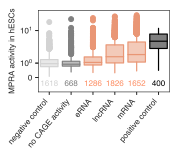

In [25]:
fig = plt.figure(figsize=(2.35, 1.5))
ax = sns.boxplot(data=human_df_w_ctrls, x="minimal_biotype_hg19", y="HUES64", flierprops = dict(marker='o', markersize=5),
                 order=min_ctrl_order, palette=min_human_ctrl_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(min_ctrl_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("MPRA activity in hESCs")

for i, label in enumerate(min_ctrl_order):
    n = len(human_df_w_ctrls[human_df_w_ctrls["minimal_biotype_hg19"] == label])
    color = min_human_ctrl_pal[label]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-1, 60))
plt.show()
fig.savefig("Fig1D_1.pdf", dpi="figure", bbox_inches="tight")
plt.close()

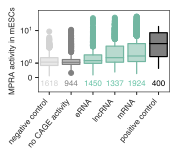

In [26]:
fig = plt.figure(figsize=(2.35, 1.5))
ax = sns.boxplot(data=mouse_df_w_ctrls, x="minimal_biotype_mm9", y="mESC", flierprops = dict(marker='o', markersize=5),
                 order=min_ctrl_order, palette=min_mouse_ctrl_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(min_ctrl_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("MPRA activity in mESCs")

for i, label in enumerate(min_ctrl_order):
    n = len(mouse_df_w_ctrls[mouse_df_w_ctrls["minimal_biotype_mm9"] == label])
    color = min_mouse_ctrl_pal[label]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-1, 60))
plt.show()
fig.savefig("Fig1D_2.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 4. compare activities across tiles

In [27]:
df = data[data["tss_tile_num"].isin(["tile1", "tile2"])]
human_df = df[df["species"] == "HUMAN"]
mouse_df = df[df["species"] == "MOUSE"]

human_df = human_df.merge(tss_map[["hg19_id", "minimal_biotype_hg19", "stem_exp_hg19", "orig_species"]], left_on="tss_id", 
                          right_on="hg19_id", how="right")
mouse_df = mouse_df.merge(tss_map[["mm9_id", "minimal_biotype_mm9", "stem_exp_mm9", "orig_species"]], left_on="tss_id", 
                          right_on="mm9_id", how="right")
mouse_df.sample(5)

HUES64      mESC   HUES64_pval     mESC_pval   HUES64_padj  \
4264  2.931334  2.595355  6.038599e-09  3.643388e-05  3.120242e-08   
2855  0.726819  0.514169  7.510181e-01  9.246428e-01  8.291582e-01   
4011  1.398480  0.956959  1.029332e-01  6.130677e-01  2.530486e-01   
3968  4.301968  3.193383  2.163898e-22  1.700002e-08  1.673133e-21   
4516  1.065450  1.226090  3.814176e-01  3.403646e-01  6.394897e-01   

         mESC_padj                                            element  \
4264  2.002637e-04  CTCGGTGACCCGCAGACCTCAGCTCTAACCTGAGCAGGAGAGCCTG...   
2855  9.320974e-01  GCCTCAGCCAGACAGGCCTAAAGGAAACTCATCCAACCAGTTTCCA...   
4011  7.715882e-01  CTGGGACGCTAATTCAGTCGGCAGAGAAGCCAAAAGGAGACTCACA...   
3968  1.137625e-07  GATGGGCGGGTTCAGAGAGGGAGACAGGGAGGGGGGTGGCGGTTAG...   
4516  6.614775e-01  GATCCTCACTTAACTGTCGGCGGAATGAACAGTGTCTGTTCACTAC...   

     tile_type                                         element_id  \
4264  WILDTYPE  MOUSE_EVO_TSS__m.490__tile2:89105279-89105423,...   
2855  WILDTYPE  MOUSE_EVO_TSS__m.2392__tile1:77648825-77648969...   
4011  WILDTYPE  MOUSE_EVO_TSS__m.2641__tile2:31087827-31087971...   
3968  WILDTYPE  MOUSE_EVO_TSS__m.2488__tile1:72817094-72817238...   
4516  WILDTYPE  MOUSE_EVO_TSS__m.2948__tile2:133372165-1333723...   

                              name     ...         dupe_info HUES64_log  \
4264   MOUSE_EVO_TSS__m.490__tile2     ...       12284.1.0.0   0.467065   
2855  MOUSE_EVO_TSS__m.2392__tile1     ...        8839.1.0.0  -0.138574   
4011  MOUSE_EVO_TSS__m.2641__tile2     ...       13832.1.0.0   0.145656   
3968  MOUSE_EVO_TSS__m.2488__tile1     ...       10862.1.0.0   0.633667   
4516  MOUSE_EVO_TSS__m.2948__tile2     ...       12003.1.0.0   0.027533   

      mESC_log  tss_id  species tss_tile_num  mm9_id  minimal_biotype_mm9  \
4264  0.414197   m.490    MOUSE        tile2   m.490                 mRNA   
2855 -0.288894  m.2392    MOUSE        tile1  m.2392               lncRNA   
4011 -0.019107  m.2641    MOUSE        tile2  m.2641               lncRNA   
3968  0.504251  m.2488    MOUSE        tile1  m.2488                other   
4516  0.088522  m.2948    MOUSE        tile2  m.2948               lncRNA   

     stem_exp_mm9 orig_species  
4264      38.0225        human  
2855      0.04625        mouse  
4011      1.23125        mouse  
3968      0.08875        mouse  
4516      0.21375        mouse  

[5 rows x 25 columns]

1.09015747541e-18
3.72111985818e-24
4.00796524248e-23
3.74100817636e-24
1.53303765887e-16
1.17479379901e-32


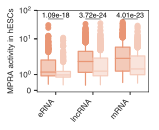

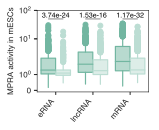

In [28]:
c = 1
for df, species, colname, color, sp in zip([human_df, mouse_df], ["hESCs", "mESCs"], ["HUES64", "mESC"], 
                                           [sns.color_palette("Set2")[1], sns.color_palette("Set2")[0]],
                                           ["hg19", "mm9"]):
    fig = plt.figure(figsize=(2, 1.5))
    ax = sns.boxplot(data=df, x="minimal_biotype_%s" % sp, y=colname, hue="tss_tile_num", 
                     flierprops = dict(marker='o', markersize=5),
                     order=["eRNA", "lncRNA", "mRNA"], hue_order=["tile1", "tile2"],
                     palette={"tile1": sns.light_palette(color)[5], "tile2": sns.light_palette(color)[2]})
    mimic_r_boxplot(ax)
    ax.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha="right", va="top")

    # calc p-vals b/w dists
    for i, label in enumerate(["eRNA", "lncRNA", "mRNA"]):
        sub = df[df["minimal_biotype_%s" % sp] == label]
        tile1_dist = np.asarray(sub[sub["tss_tile_num"] == "tile1"][colname])
        tile2_dist = np.asarray(sub[sub["tss_tile_num"] == "tile2"][colname])

        tile1_dist = tile1_dist[~np.isnan(tile1_dist)]
        tile2_dist = tile2_dist[~np.isnan(tile2_dist)]

        tile_u, tile_pval = stats.mannwhitneyu(tile1_dist, tile2_dist, alternative="two-sided", use_continuity=False)
        print(tile_pval)

        annotate_pval(ax, i-0.2, i+0.2, 50, 0, 50, tile_pval, fontsize-1)
        
    ax.set_yscale('symlog')
    ax.set_ylabel("MPRA activity in %s" % species)
    ax.set_xlabel("")
    ax.get_legend().remove()
#     ax.set_title(species)
    ax.set_ylim((-0.1, 100))
    fig.savefig("Fig1E_%s.pdf" % c, dpi="figure", bbox_inches="tight")
    c += 1

find max tile in each species

In [29]:
human_max = human_df[["hg19_id", "tss_tile_num", "HUES64"]]
human_max = human_max.sort_values(by="HUES64", ascending=False)
human_max = human_max.drop_duplicates(subset=["hg19_id"])
human_max = human_max.sort_values(by="hg19_id")
human_max.head()

hg19_id tss_tile_num    HUES64
6187     h.0          NaN       NaN
6188     h.1          NaN       NaN
833     h.10        tile2  1.006255
6198   h.100          NaN       NaN
4356  h.1000        tile1  7.941761

In [30]:
human_grp = human_df[["hg19_id", "tss_tile_num", "HUES64"]]
human_grp = human_grp[~pd.isnull(human_grp["HUES64"])]
human_grp = human_grp.groupby("hg19_id")["tss_tile_num"].agg("count").reset_index()
human_grp.columns = ["hg19_id", "n_tiles_hg19"]
print(len(human_grp))
len(human_grp[human_grp["n_tiles_hg19"] == 2])

3356


2541

In [31]:
mouse_max = mouse_df[["mm9_id", "tss_tile_num", "mESC"]]
mouse_max = mouse_max.sort_values(by="mESC", ascending=False)
mouse_max = mouse_max.drop_duplicates(subset=["mm9_id"])
mouse_max = mouse_max.sort_values(by="mm9_id")
mouse_max.head()

mm9_id tss_tile_num       mESC
6353     m.0          NaN        NaN
3461     m.1        tile1   1.179409
1274    m.10        tile1  19.783174
3689   m.100        tile1   2.389322
4792  m.1000        tile2   1.724882

In [32]:
mouse_grp = mouse_df[["mm9_id", "tss_tile_num", "mESC"]]
mouse_grp = mouse_grp[~pd.isnull(mouse_grp["mESC"])]
mouse_grp = mouse_grp.groupby("mm9_id")["tss_tile_num"].agg("count").reset_index()
mouse_grp.columns = ["mm9_id", "n_tiles_mm9"]
print(len(mouse_grp))
len(mouse_grp[mouse_grp["n_tiles_mm9"] == 2])

3272


2493

In [33]:
tss_map_mrg = tss_map.merge(human_max[["hg19_id", "tss_tile_num"]], on="hg19_id", how="left", 
                            suffixes=("", "")).merge(mouse_max[["mm9_id", "tss_tile_num"]],
                                                              on="mm9_id", how="left", suffixes=("_max_hg19", 
                                                                                                 "_max_mm9"))
tss_map_mrg = tss_map_mrg.merge(human_grp, on="hg19_id", how="left").merge(mouse_grp, on="mm9_id", how="left")
tss_map_mrg.sample(10)

hg19_id  mm9_id                 cage_id_hg19  \
1475  h.1427  m.1109      chr11:65076655-65076852   
2402  h.2352  m.2164   chr20:34287103..34287118,-   
2543  h.2493  m.2305      chr11:46270167-46270467   
269    h.269   m.171    chr4:74124877..74124918,+   
22      h.22    m.17  chr1:198906528..198906573,-   
3256  h.3120  m.2931             no cage activity   
2022  h.1972  m.1784    chrX:46187095..46187114,-   
1008   h.986   m.869   chr19:54959771..54959797,+   
3772  h.3626  m.3455  chrX:137793495..137793521,-   
1552  h.1502  m.1184      chr16:49900569-49900918   

                      cage_id_mm9                     name_peak_hg19  \
1475        chr19:5929631-5929952  chr11:65076655-65076852__POSITIVE   
2402             no cage activity                  ENSG00000244005.8   
2543             no cage activity  chr11:46270167-46270467__POSITIVE   
269     chr5:90795642..90795697,+                  ENSG00000250220.1   
22    chr1:139795137..139795194,+                  ENSG00000229989.3   
3256  chr2:149624452..149624465,-                   no cage activity   
2022             no cage activity                  ENSG00000236751.1   
1008             no cage activity                 ENSG00000167615.12   
3772    chrX:56387538..56387552,-                         unassigned   
1552       chr8:90491845-90492052  chr16:49900569-49900918__POSITIVE   

                         name_peak_mm9      biotype_hg19       biotype_mm9  \
1475   chr19:5929631-5929952__NEGATIVE          enhancer          enhancer   
2402                  no cage activity    protein_coding  no cage activity   
2543                  no cage activity          enhancer  no cage activity   
269               ENSMUSG00000054945.3         divergent    protein_coding   
22                ENSMUSG00000098243.3        intergenic        intergenic   
3256              ENSMUSG00000087029.1  no cage activity        intergenic   
2022                  no cage activity        intergenic  no cage activity   
1008                  no cage activity    protein_coding  no cage activity   
3772                        unassigned        unassigned        unassigned   
1552  chr8:90491845-90492052__NEGATIVE          enhancer          enhancer   

     minimal_biotype_hg19 minimal_biotype_mm9     ...      \
1475                 eRNA                eRNA     ...       
2402                 mRNA                mRNA     ...       
2543                 eRNA    no CAGE activity     ...       
269                lncRNA                mRNA     ...       
22                 lncRNA               other     ...       
3256     no CAGE activity              lncRNA     ...       
2022               lncRNA    no CAGE activity     ...       
1008                 mRNA    no CAGE activity     ...       
3772                other               other     ...       
1552                 eRNA                eRNA     ...       

            stem_exp_hg19      stem_exp_mm9  max_cage_hg19 max_cage_mm9  \
1475            0.0290159          0.016984           10.0        146.0   
2402             0.327778  no cage activity          549.0        324.0   
2543  0.16781400000000002  no cage activity           63.0          2.0   
269              0.636667           1.79375         1182.0       1244.0   
22              0.0677778            0.0825        34919.0      47409.0   
3256     no cage activity           0.51875            4.0         80.0   
2022                 0.24  no cage activity         1538.0          5.0   
1008  0.21777800000000003  no cage activity          873.0          7.0   
3772              1.07556               0.0          655.0        877.0   
1552                  0.0          0.306416            9.0         21.0   

     orig_species    har  tss_tile_num_max_hg19 tss_tile_num_max_mm9  \
1475        human  False                  tile1                tile2   
2402        human  False                  tile2                tile2   
2543        human  False                  tile1        

In [34]:
print(len(tss_map_mrg))
print(len(tss_map_mrg[(tss_map_mrg["n_tiles_hg19"] >= 2) & (tss_map_mrg["n_tiles_mm9"] >= 2)]))

3789
2339


In [35]:
tss_map_mrg.tss_tile_num_max_hg19.value_counts()

tile1    2100
tile2    1381
Name: tss_tile_num_max_hg19, dtype: int64

In [36]:
tss_map_mrg.tss_tile_num_max_mm9.value_counts()

tile1    2170
tile2    1356
Name: tss_tile_num_max_mm9, dtype: int64

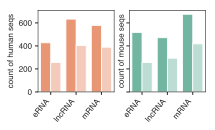

In [37]:
fig, axarr = plt.subplots(figsize=(3, 1.5), nrows=1, ncols=2, sharey=True)

ax0 = axarr[0]
ax1 = axarr[1]

sns.countplot(data=tss_map_mrg, x="minimal_biotype_hg19", hue="tss_tile_num_max_hg19", 
              order=["eRNA", "lncRNA", "mRNA"], hue_order=["tile1", "tile2"],
              palette={"tile1": sns.light_palette(sns.color_palette("Set2")[1])[5], 
                       "tile2": sns.light_palette(sns.color_palette("Set2")[1])[2]},
              ax=ax0)
ax0.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha="right", va="top")
ax0.set_xlabel("")
ax0.set_ylabel("count of human seqs")
ax0.get_legend().remove()

sns.countplot(data=tss_map_mrg, x="minimal_biotype_mm9", hue="tss_tile_num_max_mm9", 
              order=["eRNA", "lncRNA", "mRNA"], hue_order=["tile1", "tile2"],
              palette={"tile1": sns.light_palette(sns.color_palette("Set2")[0])[5], 
                       "tile2": sns.light_palette(sns.color_palette("Set2")[0])[2]},
              ax=ax1)
ax1.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha="right", va="top")
ax1.set_xlabel("")
ax1.get_legend().remove()
ax1.set_ylabel("count of mouse seqs")

fig.savefig("FigS5B.pdf", dpi="figure", bbox_inches="tight")

In [38]:
def tile_match(row):
    if pd.isnull(row.tss_tile_num_max_hg19) or pd.isnull(row.tss_tile_num_max_mm9):
        return np.nan
    else:
        if row.tss_tile_num_max_hg19 == "tile1":
            if row.tss_tile_num_max_mm9 == "tile1":
                return "tile1:tile1"
            else:
                return "tile1:tile2"
        else:
            if row.tss_tile_num_max_mm9 == "tile2":
                return "tile2:tile2"
            else:
                return "tile1:tile2"

In [39]:
tss_map_mrg["tile_match"] = tss_map_mrg.apply(tile_match, axis=1)
tss_map_mrg.tile_match.value_counts()

tile1:tile2    1374
tile1:tile1    1338
tile2:tile2     600
Name: tile_match, dtype: int64

In [40]:
tss_map_mrg[tss_map_mrg["tile_match"] == "tile1:tile2"].sample(5)

hg19_id  mm9_id                 cage_id_hg19                 cage_id_mm9  \
563    h.541   m.427  chr1:228327943..228328044,+  chr11:59005293..59005345,-   
1949  h.1899  m.1711      chr3:9440451..9440496,-            no cage activity   
3728  h.3592  m.3402             no cage activity      chr6:85320763-85321078   
2120  h.2070  m.1882   chr18:24283637..24283652,-            no cage activity   
1556  h.1506  m.1188    chr11:128445940-128446213      chr9:32454210-32454636   

                           name_peak_hg19                     name_peak_mm9  \
563                    ENSG00000143774.12             ENSMUSG00000020444.19   
1949                    ENSG00000206573.4                  no cage activity   
3728                     no cage activity  chr6:85320763-85321078__POSITIVE   
2120                    ENSG00000265369.2                  no cage activity   
1556  chr11:128445940-128446213__POSITIVE  chr9:32454210-32454636__POSITIVE   

          biotype_hg19       biotype_mm9 minimal_biotype_hg19  \
563     protein_coding    protein_coding                 mRNA   
1949         divergent  no cage activity               lncRNA   
3728  no cage activity          enhancer     no CAGE activity   
2120        intergenic  no cage activity               lncRNA   
1556          enhancer          enhancer                 eRNA   

     minimal_biotype_mm9     ...           stem_exp_mm9  max_cage_hg19  \
563                 mRNA     ...                41.4575       104329.0   
1949              lncRNA     ...       no cage activity         1328.0   
3728                eRNA     ...              0.0963865            1.0   
2120    no CAGE activity     ...       no cage activity          732.0   
1556                eRNA     ...                    0.0            8.0   

      max_cage_mm9 orig_species    har  tss_tile_num_max_hg19  \
563        25373.0        human  False                  tile1   
1949          37.0        human  False                  tile1   
3728          67.0        mouse  False                  tile1   
2120           2.0        human  False                  tile1   
1556          12.0        human  False                  tile1   

      tss_tile_num_max_mm9 n_tiles_hg19 n_tiles_mm9   tile_match  
563                  tile2          2.0         1.0  tile1:tile2  
1949                 tile2          2.0         2.0  tile1:tile2  
3728                 tile2          2.0         2.0  tile1:tile2  
2120                 tile2          2.0         2.0  tile1:tile2  
1556                 tile2          2.0         4.0  tile1:tile2  

[5 rows x 31 columns]

In [41]:
human_df[human_df["hg19_id"] == "h.299"][["hg19_id", "tss_tile_num", "HUES64"]].sort_values(by="tss_tile_num")

hg19_id tss_tile_num    HUES64
5799   h.299        tile1  1.368039
5800   h.299        tile2  1.634826

In [42]:
mouse_df[mouse_df["mm9_id"] == "m.192"][["mm9_id", "tss_tile_num", "mESC"]].sort_values(by="tss_tile_num")

mm9_id tss_tile_num      mESC
2022  m.192        tile1  2.174230
2023  m.192        tile2  1.228158

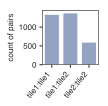

In [43]:
fig = plt.figure(figsize=(1, 1))

ax = sns.countplot(data=tss_map_mrg, x="tile_match", color=sns.color_palette("Set2")[2])
ax.set_xticklabels(["tile1:tile1", "tile1:tile2", "tile2:tile2"], rotation=50, ha="right", va="top")

ax.set_xlabel("")
ax.set_ylabel("count of pairs")
fig.savefig("FigS5C.pdf", dpi="figure", bbox_inches="tight")

## 5. correlate MPRA activities w/ endogenous activs

In [44]:
human_tmp = human_df_w_ctrls
human_tmp.columns

Index(['HUES64', 'HUES64_log', 'HUES64_padj', 'HUES64_pval', 'actual_end',
       'actual_start', 'chrom', 'dupe_info', 'element', 'element_id', 'mESC',
       'mESC_log', 'mESC_padj', 'mESC_pval', 'name', 'species', 'strand',
       'tile_number', 'tile_type', 'tss_id', 'tss_tile_num', 'hg19_id',
       'biotype_hg19', 'minimal_biotype_hg19', 'stem_exp_hg19', 'orig_species',
       'max_cage_hg19'],
      dtype='object')

In [45]:
human_tmp["stem_exp_hg19_fixed"] = human_tmp.apply(fix_cage_exp, col="stem_exp_hg19", axis=1)
human_tmp.sample(5)

HUES64  HUES64_log   HUES64_padj   HUES64_pval   actual_end  \
5627  3.595447    0.555753  8.094578e-14  1.273180e-14  150421802.0   
5334  1.253225    0.098029  4.240584e-01  1.990896e-01   37394064.0   
638   6.516090    0.813987  2.943211e-57  2.167276e-58          0.0   
8182  5.617050    0.749508  1.322694e-40  1.226534e-41          NaN   
1447  0.878844   -0.056088  7.727130e-01  5.940512e-01  127568844.0   

      actual_start  chrom   dupe_info  \
5627   150421658.0   chr3  5028.1.0.0   
5334    37393920.0  chr15  2337.1.0.0   
638            0.0    NaN        none   
8182           NaN    NaN         NaN   
1447   127568700.0   chr8  6762.1.0.0   

                                                element  \
5627  GGTGGCGCAGGGCAAGCAGTTGCCCGGGGAGACCAACGCACAACAG...   
5334  GGCTTCACCTCTGCGCGGCTGGTTTCCCGGCGGCCGCGCGTCAATC...   
638   ACCGACGCATATCCGGCTACGTCAGTGCCCCCTGAAGGGAAGCGTT...   
8182  TGGATAGCGGTTTGACTCACGGGGATTTCCAAGTCTCCACCCCATT...   
1447  ATCAGTGTGCCACTGCCTCTCCGTCCTCCTCCTCGGAGCTGGGCGC...   

                                             element_id         ...          \
5627  HUMAN_EVO_TSS__h.1034__tile1:150421658-1504218...         ...           
5334  HUMAN_EVO_TSS__h.3245__tile1:37393920-37394064...         ...           
638                             random_sequence_605;605         ...           
8182                                                NaN         ...           
1447  HUMAN_EVO_TSS__h.360__tile1:127568700-12756884...         ...           

      tile_type  tss_id  tss_tile_num  hg19_id      biotype_hg19  \
5627   WILDTYPE  h.1034         tile1   h.1034    protein_coding   
5334   WILDTYPE  h.3245         tile1   h.3245  no cage activity   
638      RANDOM    None          None      NaN               NaN   
8182        NaN     NaN           NaN      NaN               NaN   
1447   WILDTYPE   h.360         tile1    h.360         antisense   

     minimal_biotype_hg19     stem_exp_hg19  orig_species max_cage_hg19  \
5627                 mRNA              0.26         human         413.0   
5334               lncRNA  no cage activity         mouse         189.0   
638      negative control               NaN           NaN           NaN   
8182     positive control               NaN           NaN           NaN   
1447                other              0.07         human          79.0   

     stem_exp_hg19_fixed  
5627                0.26  
5334                0.00  
638                  NaN  
8182                 NaN  
1447                0.07  

[5 rows x 28 columns]

2724


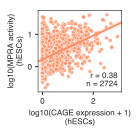

2795


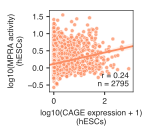

In [46]:
for tile_num in ["tile1", "tile2"]:
    df = human_tmp[(human_tmp["tss_tile_num"] == tile_num) & 
                   (~human_tmp["minimal_biotype_hg19"].isin(["no CAGE activity"]))]
    
    fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)

    df["stem_exp_hg19_log"] = np.log10(df["stem_exp_hg19_fixed"] + 1)
    sub = df[~pd.isnull(df["HUES64_log"])]
    print(len(sub))

    sns.regplot(data=sub, x="stem_exp_hg19_log", y="HUES64_log", color=min_human_ctrl_pal["mRNA"], 
                scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, fit_reg=True, ax=ax)

    # annotate corr
    no_nan = sub[(~pd.isnull(sub["stem_exp_hg19_log"])) & (~pd.isnull(sub["HUES64_log"]))]
    r, p = spearmanr(no_nan["stem_exp_hg19_log"], no_nan["HUES64_log"])

    ax.text(0.95, 0.15, "r = {:.2f}".format(r), ha="right", va="bottom", fontsize=fontsize,
        transform=ax.transAxes)
    ax.text(0.95, 0.05, "n = %s" % (len(no_nan)), ha="right", va="bottom", fontsize=fontsize,
            transform=ax.transAxes)

    ax.set_xlabel("log10(CAGE expression + 1)\n(hESCs)")
    ax.set_ylabel("log10(MPRA activity)\n(hESCs)")

    plt.show()
    #fig.savefig("cage_corr_human.all.%s.pdf" % tile_num, dpi="figure", bbox_inches="tight")
    plt.close()

3055


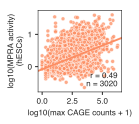

3132


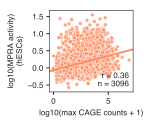

In [47]:
for tile_num in ["tile1", "tile2"]:
    df = human_tmp[(human_tmp["tss_tile_num"] == tile_num)]
    
    fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)

    sub = df[~pd.isnull(df["HUES64_log"])]
    sub["cage_log"] = np.log10(sub["max_cage_hg19"] + 1)
    print(len(sub))

    sns.regplot(data=sub, x="cage_log", y="HUES64_log", color=min_human_ctrl_pal["mRNA"], 
                scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, fit_reg=True, ax=ax)

    # annotate corr
    no_nan = sub[(~pd.isnull(sub["cage_log"])) & (~pd.isnull(sub["HUES64_log"]))]
    r, p = spearmanr(no_nan["cage_log"], no_nan["HUES64_log"])

    ax.text(0.95, 0.15, "r = {:.2f}".format(r), ha="right", va="bottom", fontsize=fontsize,
        transform=ax.transAxes)
    ax.text(0.95, 0.05, "n = %s" % (len(no_nan)), ha="right", va="bottom", fontsize=fontsize,
            transform=ax.transAxes)

    ax.set_xlabel("log10(max CAGE counts + 1)")
    ax.set_ylabel("log10(MPRA activity)\n(hESCs)")

    plt.show()
    #fig.savefig("cage_corr_human.all.%s.pdf" % tile_num, dpi="figure", bbox_inches="tight")
    plt.close()

In [48]:
mouse_tmp = mouse_df_w_ctrls
mouse_tmp["stem_exp_mm9_fixed"] = mouse_tmp.apply(fix_cage_exp, col="stem_exp_mm9", axis=1)
len(mouse_tmp)

8371

2678


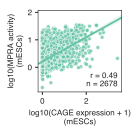

2731


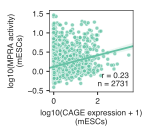

In [49]:
for tile_num in ["tile1", "tile2"]:
    df = mouse_tmp[(mouse_tmp["tss_tile_num"] == tile_num) & 
                   (~mouse_tmp["minimal_biotype_mm9"].isin(["no CAGE activity"]))]
    
    fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)

    df["stem_exp_mm9_log"] = np.log10(df["stem_exp_mm9_fixed"] + 1)
    sub = df[~pd.isnull(df["mESC_log"])]
    print(len(sub))

    sns.regplot(data=sub, x="stem_exp_mm9_log", y="mESC_log", color=min_mouse_ctrl_pal["mRNA"], 
                scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, fit_reg=True, ax=ax)

    # annotate corr
    no_nan = sub[(~pd.isnull(sub["stem_exp_mm9_log"])) & (~pd.isnull(sub["mESC_log"]))]
    r, p = spearmanr(no_nan["stem_exp_mm9_log"], no_nan["mESC_log"])

    ax.text(0.95, 0.15, "r = {:.2f}".format(r), ha="right", va="bottom", fontsize=fontsize,
        transform=ax.transAxes)
    ax.text(0.95, 0.05, "n = %s" % (len(no_nan)), ha="right", va="bottom", fontsize=fontsize,
            transform=ax.transAxes)

    ax.set_xlabel("log10(CAGE expression + 1)\n(mESCs)")
    ax.set_ylabel("log10(MPRA activity)\n(mESCs)")

    plt.show()
#     fig.savefig("cage_corr_mouse.all.%s.pdf" % tile_num, dpi="figure", bbox_inches="tight")
    plt.close()

3147


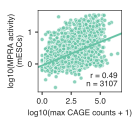

3206


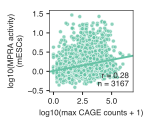

In [50]:
for tile_num in ["tile1", "tile2"]:
    df = mouse_tmp[(mouse_tmp["tss_tile_num"] == tile_num)]
    
    fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)

    sub = df[~pd.isnull(df["mESC_log"])]
    sub["cage_log"] = np.log10(sub["max_cage_mm9"] + 1)
    print(len(sub))

    sns.regplot(data=sub, x="cage_log", y="mESC_log", color=min_mouse_ctrl_pal["mRNA"], 
                scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, fit_reg=True, ax=ax)

    # annotate corr
    no_nan = sub[(~pd.isnull(sub["cage_log"])) & (~pd.isnull(sub["mESC_log"]))]
    r, p = spearmanr(no_nan["cage_log"], no_nan["mESC_log"])

    ax.text(0.95, 0.15, "r = {:.2f}".format(r), ha="right", va="bottom", fontsize=fontsize,
        transform=ax.transAxes)
    ax.text(0.95, 0.05, "n = %s" % (len(no_nan)), ha="right", va="bottom", fontsize=fontsize,
            transform=ax.transAxes)

    ax.set_xlabel("log10(max CAGE counts + 1)")
    ax.set_ylabel("log10(MPRA activity)\n(mESCs)")

    plt.show()
    #fig.savefig("cage_corr_mouse.all.%s.pdf" % tile_num, dpi="figure", bbox_inches="tight")
    plt.close()

## 6. how does endogenous CAGE expr compare between human and mouse

In [51]:
human_tmp["species"] = "human"
mouse_tmp["species"] = "mouse"

human_tmp = human_tmp[["tss_id", "minimal_biotype_hg19", "stem_exp_hg19_fixed", "species", "max_cage_hg19"]]
human_tmp.columns = ["tss_id", "minimal_biotype", "stem_exp_fixed", "species", "max_cage"]
mouse_tmp = mouse_tmp[["tss_id", "minimal_biotype_mm9", "stem_exp_mm9_fixed", "species", "max_cage_mm9"]]
mouse_tmp.columns = ["tss_id", "minimal_biotype", "stem_exp_fixed", "species", "max_cage"]

tmp = human_tmp.append(mouse_tmp)
tmp["log_stem"] = np.log10(tmp["stem_exp_fixed"]+1)
tmp["log_max"] = np.log10(tmp["max_cage"]+1)
tmp.head(5)

tss_id minimal_biotype  stem_exp_fixed species  max_cage  log_stem  \
0  h.1133            eRNA        0.203060   human      55.0  0.080287   
1  h.1436            eRNA        0.039044   human      47.0  0.016634   
2  h.1951          lncRNA        0.028889   human    9592.0  0.012368   
3  h.1237            eRNA        0.029016   human       7.0  0.012422   
4  h.2803           other        0.000000   human      36.0  0.000000   

    log_max  
0  1.748188  
1  1.681241  
2  3.981954  
3  0.903090  
4  1.568202

In [52]:
tmp_pal = {"human": sns.color_palette("Set2")[1], "mouse": sns.color_palette("Set2")[0]}

2.26691144555e-06
0.00707439578848
0.0196797572038


(-1.25, 1500)

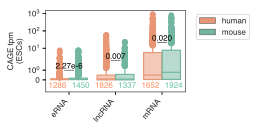

In [53]:
fig = plt.figure(figsize=(2.5, 1.5))

ax = sns.boxplot(data=tmp, x="minimal_biotype", y="stem_exp_fixed", hue="species",
                 flierprops = dict(marker='o', markersize=5),
                 order=["eRNA", "lncRNA", "mRNA"], palette=tmp_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("CAGE tpm\n(ESCs)")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

ys = [1, 2, 22]
for i, label in enumerate(["eRNA", "lncRNA", "mRNA"]):
    sub = tmp[tmp["minimal_biotype"] == label]
    human = sub[sub["species"] == "human"]
    mouse = sub[sub["species"] == "mouse"]
    
    human_vals = np.asarray(human["stem_exp_fixed"])
    mouse_vals = np.asarray(mouse["stem_exp_fixed"])

    human_vals = human_vals[~np.isnan(human_vals)]
    mouse_vals = mouse_vals[~np.isnan(mouse_vals)]

    u, pval = stats.mannwhitneyu(human_vals, mouse_vals, alternative="two-sided", use_continuity=False)
    print(pval)
    
    if pval >= 0.05:
        annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize)
    else:
        annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize)
    
    n_human = len(human)
    n_mouse = len(mouse)

    ax.annotate(str(n_human), xy=(i-0.25, -1), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=tmp_pal["human"], size=fontsize)
    ax.annotate(str(n_mouse), xy=(i+0.25, -1), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=tmp_pal["mouse"], size=fontsize)

ax.set_ylim((-1.25, 1500))
#fig.savefig("human_v_mouse_cage.min.pdf", dpi="figure", bbox_inches="tight")

0.0879082882348
8.80600287363e-12
0.206816191506


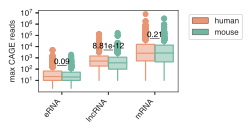

In [54]:
fig = plt.figure(figsize=(2.5, 1.5))

ax = sns.boxplot(data=tmp, x="minimal_biotype", y="max_cage", hue="species",
                 flierprops = dict(marker='o', markersize=5),
                 order=["eRNA", "lncRNA", "mRNA"], palette=tmp_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("max CAGE reads")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

ys = [200, 5000, 50000]
for i, label in enumerate(["eRNA", "lncRNA", "mRNA"]):
    sub = tmp[tmp["minimal_biotype"] == label]
    human = sub[sub["species"] == "human"]
    mouse = sub[sub["species"] == "mouse"]
    
    human_vals = np.asarray(human["max_cage"])
    mouse_vals = np.asarray(mouse["max_cage"])

    human_vals = human_vals[~np.isnan(human_vals)]
    mouse_vals = mouse_vals[~np.isnan(mouse_vals)]

    u, pval = stats.mannwhitneyu(human_vals, mouse_vals, alternative="two-sided", use_continuity=False)
    print(pval)
    
    if pval >= 0.05:
        annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize)
    else:
        annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize)
    
    n_human = len(human)
    n_mouse = len(mouse)

    ax.annotate(str(n_human), xy=(i-0.25, -1), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=tmp_pal["human"], size=fontsize)
    ax.annotate(str(n_mouse), xy=(i+0.25, -1), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=tmp_pal["mouse"], size=fontsize)

#ax.set_ylim((-1.25, 1500))
#fig.savefig("human_v_mouse_cage.min.pdf", dpi="figure", bbox_inches="tight")

## 7. write files

In [55]:
human_df_filename = "%s/human_TSS_vals.both_tiles.txt" % data_dir
mouse_df_filename = "%s/mouse_TSS_vals.both_tiles.txt" % data_dir

In [56]:
human_df.to_csv(human_df_filename, sep="\t", index=False)
mouse_df.to_csv(mouse_df_filename, sep="\t", index=False)

In [57]:
tss_map_mrg.to_csv("../../../data/01__design/01__mpra_list/mpra_tss.with_ids.RECLASSIFIED_WITH_MAX.txt", sep="\t", index=False)